# Locally Linear Stream Reference Frames on Perfect Data

In [1]:
"""
    TITLE   : Locally Linear Stream Reference Frame
    PROJECT : Stream Tracks
""";

__author__ = 'Nathaniel Starkman'

<span style='font-size:30px;font-weight:650'>
    About
</span>

A common technique is 


<br><br>

- - - 


## Prepare

### Imports

In [2]:
from utilipy import ipython

ipython.run_imports(
    base=True, astropy=True,
    matplotlib=True, plotly=True
)

# BUILT-IN

import sys; sys.path.insert(0, "../../")  # noqa

# THIRD PARTY

from astropy.visualization import imshow_norm
import corner
import lmfit as lf
import scipy.optimize as opt
from utilipy.data_utils.fitting import scipy_residual_to_lmfit, scipy_function_to_astropy_model


# PROJECT-SPECIFIC

import streamtrack as st
from streamtrack.examples import example_coords
from streamtrack.utils.coordinates import cartesian_to_spherical, reference_to_skyoffset_matrix, get_transform_matrix
from streamtrack.fit_rotated_frame import cartesian_model, residual

set autoreload to 1


In [3]:
ipython.set_autoreload(2)

set autoreload to 2


<br><br>

- - - 


## Data

Mock Data

In [4]:
rsc = example_coords.RotatedICRS(
    phi1=np.linspace(0, 2*np.pi, 128)*u.radian,
    phi2=np.zeros(128)*u.radian
)

icrs = rsc.transform_to(coord.ICRS)


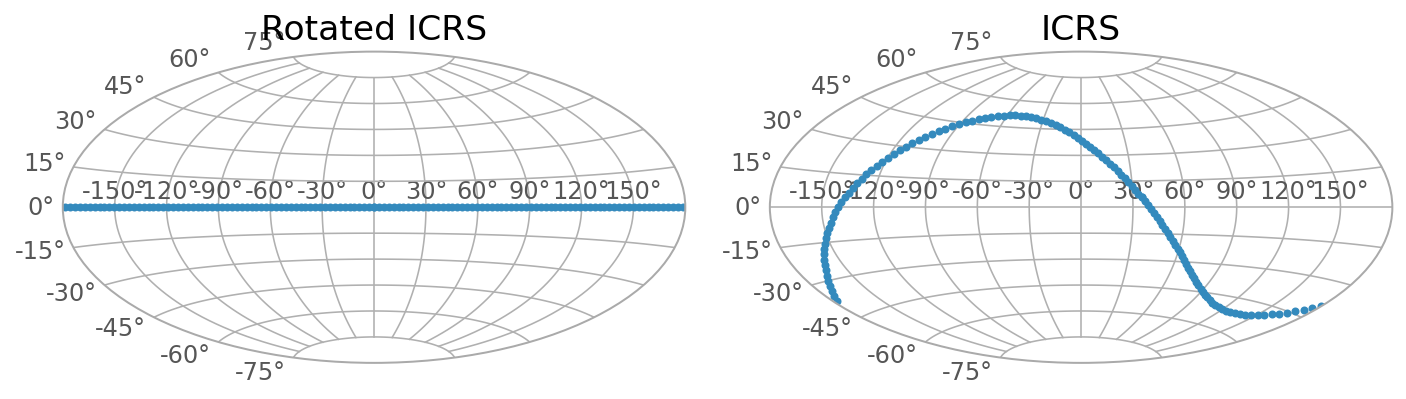

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         subplot_kw={'projection': 'aitoff'})

axes[0].set_title("Rotated ICRS")
axes[0].plot(rsc.phi1.wrap_at(180*u.deg).radian, rsc.phi2.radian,
             linestyle='none', marker='.')

axes[1].set_title("ICRS")
axes[1].plot(icrs.ra.wrap_at(180*u.deg).radian, icrs.dec.radian,
             linestyle='none', marker='.')

plt.tight_layout()
plt.show();

<br><br>

- - - 


## Testing Transformation Matrices

Deriving matrix from RotatedICRS (Cartesian) to ICRS (Cartesian)

TODO have as pytest

In [6]:
# Direct derivation

test_rot = reference_to_skyoffset_matrix(
    example_coords.RA,
    example_coords.DEC,
    example_coords.ROTATION
)

print("Matrix matches original?", np.allclose(test_rot, example_coords.ROT_MATRIX))

# From the SkyOffset frame

test_rot = get_transform_matrix(
    SkyCoord(ra=example_coords.RA, dec=example_coords.DEC).skyoffset_frame(
        rotation=example_coords.ROTATION
    ),
    coord.ICRS
)
test_rot

print("Matrix matches?", np.allclose(test_rot, example_coords.ROT_MATRIX))

Matrix matches original? True


array([[ 0.81379768,  0.57292918,  0.09739349],
       [ 0.29619813, -0.55309513,  0.77868636],
       [ 0.5       , -0.60484538, -0.61980809]])

Matrix matches? True


Getting transformation matrix from RotatedICRS (Cartesian) to ICRS (Cartesian)

In [7]:
rot_matrix = get_transform_matrix(coord.ICRS, rsc)

print("Matrix matches?", np.allclose(rot_matrix, example_coords.ROT_MATRIX))

rot_matrix

Matrix matches? True


array([[ 0.81379768,  0.57292918,  0.09739349],
       [ 0.29619813, -0.55309513,  0.77868636],
       [ 0.5       , -0.60484538, -0.61980809]])

Testing transformation

In [8]:
icrs_xyz = np.dot(rot_matrix, rsc.cartesian.xyz)

print("Reversing transformatino worked?", np.allclose(icrs_xyz, icrs_xyz))

# and just confirming 

new_icrs = coord.ICRS(x=icrs_xyz[0], y=icrs_xyz[1], z=icrs_xyz[2], representation_type="cartesian")

print("Extra check worked?", np.allclose(new_icrs.cartesian.xyz, icrs_xyz))

Reversing transformatino worked? True
Extra check worked? True


<br><br>

- - - 


## Residual Function

Showing over a grid.

Text(0.5, 0, '$\\theta$')

Text(0, 0.5, 'residual')

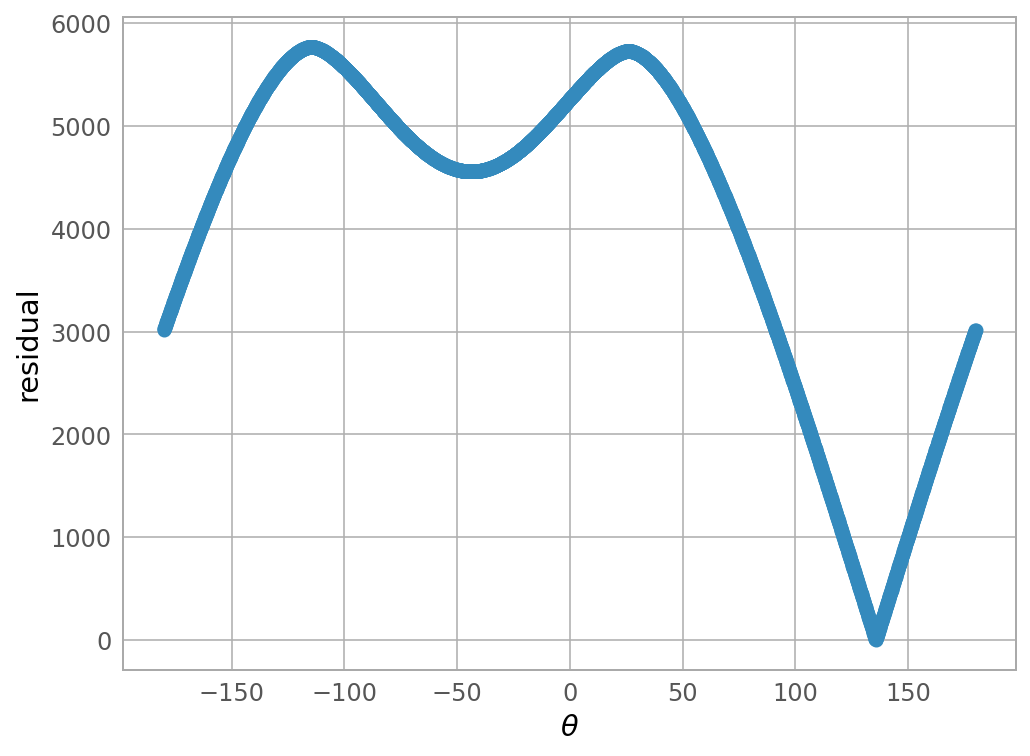

In [9]:
rs = np.linspace(-180, 180, num=3600)
res = np.array(
    [residual(
        (r, example_coords.RA.value, example_coords.DEC.value),
        data=icrs.cartesian,
        scalar=True
     )
     for r in rs]
)

plt.scatter(rs, res)
plt.xlabel(r"$\theta$")
plt.ylabel(r"residual")

In [10]:
rs = np.linspace(-180, 180, num=3600)
res2 = np.array(
    [residual(
        (r, example_coords.RA.value, example_coords.DEC.value),
        data=icrs.cartesian, scalar=False)
     for r in rs]
)

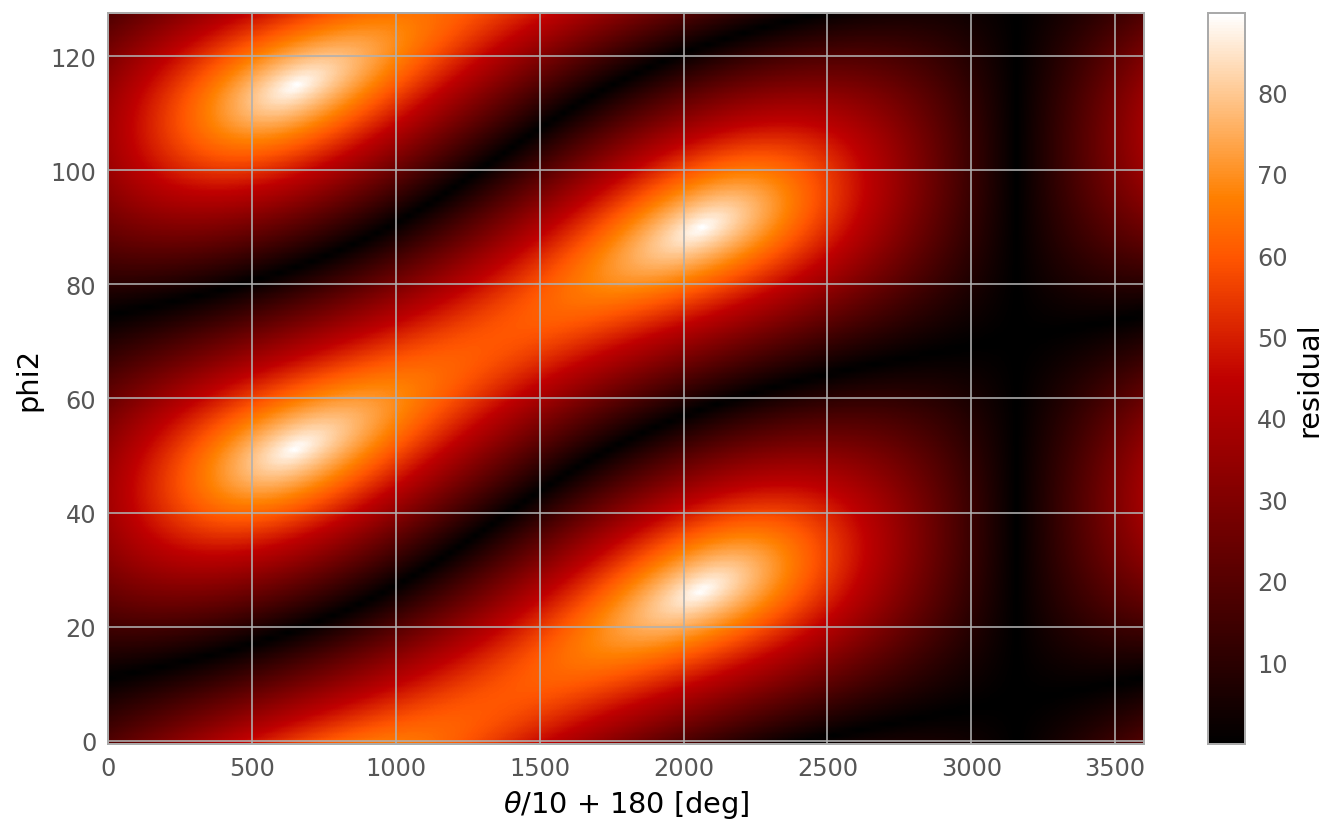

In [11]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

im, norm = imshow_norm(res2.T, ax=ax, aspect="auto", origin="lower")
plt.xlabel(r"$\theta$/10 + 180 [deg]")
plt.ylabel(r"phi2")

cbar = fig.colorbar(im)
cbar.ax.set_ylabel("residual")
plt.tight_layout();

**TODO** a plot of all the orbits colored by their probability

<br><br>

- - - 


## Scipy Minimization

In [12]:
bounds = np.array([
    (-180, 180),
    (example_coords.RA.value-0.001, example_coords.RA.value+0.001),
    (example_coords.DEC.value-0.001, example_coords.DEC.value+0.001),
])
bounds

array([[-180.   ,  180.   ],
       [  19.999,   20.001],
       [  29.999,   30.001]])

In [13]:
res_scipy = opt.least_squares(
    residual,
    x0 = [61, example_coords.RA.value, example_coords.DEC.value],
    args=(
        icrs.cartesian,
        False
    ),
    method="trf",
    bounds=bounds.T
)

# res_scipy
res_scipy.x

array([135.69999893,  19.99993311,  30.00015497])

In [14]:
res_scipy2 = opt.minimize(
    residual,
    x0 = [61, example_coords.RA.value, example_coords.DEC.value],
    args=(
        icrs.cartesian,
        True
    ),
    method="slsqp",
    bounds=bounds
)

res_scipy2

     fun: 2.3025767049360705e-05
     jac: array([ 66.93723356,   0.        , -23.87604127])
 message: 'Optimization terminated successfully.'
    nfev: 130
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([135.70000003,  20.        ,  29.99999972])

<br><br>

- - - 


## `lmfit` Minimization

In [15]:
params = lf.Parameters()
params.add_many(
    ("rotation", -40, True, -180, 180),
    ("lon", example_coords.RA.value, True, 18, 22),
    ("lat", example_coords.DEC.value, True, 28, 32),
)
params

name,value,initial value,min,max,vary
rotation,-40.0000000,-40,-180.000000,180.000000,True
lon,20.0000000,20.0,18.0000000,22.0000000,True
lat,30.0000000,30.0,28.0000000,32.0000000,True


In [16]:
mi = lf.minimize(
    residual.lmfit,
    params,
    kws=dict(data=icrs.cartesian, scalar=False),
    method="powell",
    calc_covar=True,
)
mi

In [17]:
# _params = params.copy()
# _params["rotation"].value = mi.params["rotation"].value + 10

# mi2 = lf.minimize(
#     residual.lmfit,
#     params,
#     kws=dict(data=icrs.cartesian, scalar=False),
#     method="least_squares",
#     calc_covar=False
# )
# mi2

Doing `emceee`

In [18]:
do_emcee = False

if do_emcee:
    mi.params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))
    
    mc = lf.minimize(
        residual.lmfit, kws=dict(data=icrs.cartesian.xyz.value, scalar=False),
        method='emcee', nan_policy='omit', burn=300,
        steps=int(1e5), thin=20,
        params=mi.params, is_weighted=False, progress=False
    )

    print('median of posterior probability distribution')
    print('--------------------------------------------')
    lf.report_fit(mc.params)

    emcee_plot = corner.corner(
        mc.flatchain, labels=mc.var_names,
        truths=list(mc.params.valuesdict().values())
    )

<br><br>

- - - 


## Astropy Minimization

In [19]:
from astropy.modeling import custom_model
from astropy.modeling.models import Mapping
from astropy.modeling import models, fitting
from astropy.utils.codegen import make_function_with_signature

In [20]:
compat = make_function_with_signature(
    cartesian_model, args=("data", ), kwargs={"rotation": 100, "lon": 20, "lat": 30},
    name=cartesian_model.__name__)
Model = custom_model(compat)

Model.n_outputs = 3
Model.inputs_no_broadcast = [0, ]

am = Model()
# am(icrs.cartesian)

In [21]:
@custom_model()
def return_data(arg):  # arg is fake parameter
    return icrs.cartesian  # .xyz.value

return_data.n_outputs = 1

# am = Model()
am.fixed["lon"] = True
am.fixed["lat"] = True

amm = return_data() | am | Mapping((2,))

amm

# amm(np.zeros(len(icrs)))
fit = fitting.LevMarLSQFitter()
fitted = fit(amm, np.zeros(len(icrs)), np.zeros(len(icrs)))

<CompoundModel(rotation_1=100., lon_1=20., lat_1=30.)>

In [22]:
fitted

<CompoundModel(rotation_1=135.7, lon_1=20., lat_1=30.)>

<br><br>

- - - 


## Breaking Degeneracy

There is a 180 degree degeneracy in any solution. We solve this by using the kinematics, such that the positive $\phi_1$ corresponds to the direction of motion.

<br><br>

- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>